In [1]:
#######################CODE FROM IACOPO LACOPINI####################
import networkx as nx
import numpy as np
from scipy import integrate


def disparity_filter(G, weight='weight'):
    ''' Compute significance scores (alpha) for weighted edges in G as defined in Serrano et al. 2009
        Args
            G: Weighted NetworkX graph
        Returns
            Weighted graph with a significance score (alpha) assigned to each edge
        References
            M. A. Serrano et al. (2009) Extracting the Multiscale backbone of complex weighted networks. PNAS, 106:16, pp. 6483-6488.
    '''
    
    if nx.is_directed(G): #directed case    
        N = nx.DiGraph()
        for u in G:
            
            k_out = G.out_degree(u)
            k_in = G.in_degree(u)
            
            if k_out > 1:
                sum_w_out = sum(np.absolute(G[u][v][weight]) for v in G.successors(u))
                for v in G.successors(u):
                    w = G[u][v][weight]
                    p_ij_out = float(np.absolute(w))/sum_w_out
                    alpha_ij_out = 1 - (k_out-1) * integrate.quad(lambda x: (1-x)**(k_out-2), 0, p_ij_out)[0]
                    N.add_edge(u, v, weight = w, alphaout=float('%.4f' % alpha_ij_out))
                    
            elif k_out == 1 and G.in_degree(G.successors(u)[0]) == 1:
                #we need to keep the connection as it is the only way to maintain the connectivity of the network
                v = G.successors(u)[0]
                w = G[u][v][weight]
                N.add_edge(u, v, weight = w, alphaout=0., alphain=0.)
                #there is no need to do the same for the k_in, since the link is built already from the tail
            
            if k_in > 1:
                sum_w_in = sum(np.absolute(G[v][u][weight]) for v in G.predecessors(u))
                for v in G.predecessors(u):
                    w = G[v][u][weight]
                    p_ij_in = float(np.absolute(w))/sum_w_in
                    alpha_ij_in = 1 - (k_in-1) * integrate.quad(lambda x: (1-x)**(k_in-2), 0, p_ij_in)[0]
                    N.add_edge(v, u, weight = w, alphain=float('%.4f' % alpha_ij_in))
        return N
    
    else: #undirected case
        B = nx.Graph()
        for u in G:
            k = len(G[u])
            if k > 1:
                sum_w = sum(np.absolute(G[u][v][weight]) for v in G[u])
                for v in G[u]:
                    w = G[u][v][weight]
                    p_ij = float(np.absolute(w))/sum_w
                    alpha_ij = 1 - (k-1) * integrate.quad(lambda x: (1-x)**(k-2), 0, p_ij)[0]
                    B.add_edge(u, v, weight = w, alpha=float('%.4f' % alpha_ij))
        return B

def disparity_filter_alpha_cut(G,weight='weight',alpha_t=0.4, cut_mode='or'):
    ''' Performs a cut of the graph previously filtered through the disparity_filter function.
        
        Args
        ----
        G: Weighted NetworkX graph
        
        weight: string (default='weight')
            Key for edge data used as the edge weight w_ij.
            
        alpha_t: double (default='0.4')
            The threshold for the alpha parameter that is used to select the surviving edges.
            It has to be a number between 0 and 1.
            
        cut_mode: string (default='or')
            Possible strings: 'or', 'and'.
            It works only for directed graphs. It represents the logic operation to filter out edges
            that do not pass the threshold value, combining the alpha_in and alpha_out attributes
            resulting from the disparity_filter function.
            
            
        Returns
        -------
        B: Weighted NetworkX graph
            The resulting graph contains only edges that survived from the filtering with the alpha_t threshold
    
        References
        ---------
        .. M. A. Serrano et al. (2009) Extracting the Multiscale backbone of complex weighted networks. PNAS, 106:16, pp. 6483-6488.
    '''    
    
    
    if nx.is_directed(G):#Directed case:   
        B = nx.DiGraph()
        for u, v, w in G.edges(data=True):
            try:
                alphain =  w['alphain']
            except KeyError: #there is no alpha_in, so we assign 1. It will never pass the cut
                alphain = 1
            try:
                alphaout =  w['alphaout']
            except KeyError: #there is no alpha_out, so we assign 1. It will never pass the cut
                alphaout = 1  
            
            if cut_mode == 'or':
                if alphain<alpha_t or alphaout<alpha_t:
                    B.add_edge(u,v, weight=w[weight])
            elif cut_mode == 'and':
                if alphain<alpha_t and alphaout<alpha_t:
                    B.add_edge(u,v, weight=w[weight])
        return B

    else:
        B = nx.Graph()#Undirected case:   
        for u, v, w in G.edges(data=True):
            
            try:
                alpha = w['alpha']
            except KeyError: #there is no alpha, so we assign 1. It will never pass the cut
                alpha = 1
                
            if alpha<alpha_t:
                B.add_edge(u,v, weight=w[weight])
        return B                
            
if __name__ == '__main__':
    G=nx.read_gml("2011.gml")
    G.remove_edges_from(nx.selfloop_edges(G))
    alpha = 0.1
    G = disparity_filter(G)
    
    G2 = nx.Graph([(u, v, d) for u, v, d in G.edges(data=True) if d['alphaout'] < alpha])
    print ('alpha = %s' % alpha)
    print ('original: nodes = %s, edges = %s' % (G.number_of_nodes(), G.number_of_edges()))
    print ('backbone: nodes = %s, edges = %s' % (G2.number_of_nodes(), G2.number_of_edges()))
    print (G2.edges(data=True))

alpha = 0.1
original: nodes = 35, edges = 1160
backbone: nodes = 35, edges = 100
[('LAKSHADWEEP', 'UTTAR PRADESH', {'weight': 316, 'alphaout': 0.0447, 'alphain': 0.9927}), ('LAKSHADWEEP', 'BIHAR', {'weight': 438, 'alphaout': 0.0123, 'alphain': 0.9569}), ('LAKSHADWEEP', 'KERALA', {'weight': 1307, 'alphaout': 0.0, 'alphain': 0.871}), ('UTTAR PRADESH', 'CHHATTISGARH', {'weight': 31435, 'alphaout': 0.0235, 'alphain': 0.4779}), ('UTTAR PRADESH', 'JHARKHAND', {'weight': 47892, 'alphaout': 0.0858, 'alphain': 0.3226}), ('UTTAR PRADESH', 'UTTARAKHAND', {'weight': 363951, 'alphaout': 0.0764, 'alphain': 0.0}), ('UTTAR PRADESH', 'JAMMU & KASHMIR', {'weight': 10726, 'alphaout': 0.0437, 'alphain': 0.7788}), ('UTTAR PRADESH', 'HARYANA', {'weight': 472193, 'alphaout': 0.0342, 'alphain': 0.0}), ('UTTAR PRADESH', 'WEST BENGAL', {'weight': 69399, 'alphain': 0.1916, 'alphaout': 0.0884}), ('UTTAR PRADESH', 'MADHYA PRADESH', {'weight': 191711, 'alphain': 0.0084, 'alphaout': 0.0028}), ('UTTAR PRADESH', 'NCT 

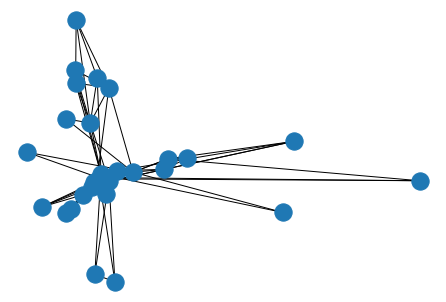

In [2]:
nx.draw(G2)

In [3]:
nx.write_gml(G2,"2011backbone.gml")

In [25]:
#######################CODE FROM IACOPO LACOPINI####################
import networkx as nx
import numpy as np
from scipy import integrate


def disparity_filter(G, weight='weight'):
    ''' Compute significance scores (alpha) for weighted edges in G as defined in Serrano et al. 2009
        Args
            G: Weighted NetworkX graph
        Returns
            Weighted graph with a significance score (alpha) assigned to each edge
        References
            M. A. Serrano et al. (2009) Extracting the Multiscale backbone of complex weighted networks. PNAS, 106:16, pp. 6483-6488.
    '''
    
    if nx.is_directed(G): #directed case    
        N = nx.DiGraph()
        for u in G:
            
            k_out = G.out_degree(u)
            k_in = G.in_degree(u)
            
            if k_out > 1:
                sum_w_out = sum(np.absolute(G[u][v][weight]) for v in G.successors(u))
                for v in G.successors(u):
                    w = G[u][v][weight]
                    p_ij_out = float(np.absolute(w))/sum_w_out
                    alpha_ij_out = 1 - (k_out-1) * integrate.quad(lambda x: (1-x)**(k_out-2), 0, p_ij_out)[0]
                    N.add_edge(u, v, weight = w, alpha_out=float('%.4f' % alpha_ij_out))
                    
            elif k_out == 1 and G.in_degree(G.successors(u)[0]) == 1:
                #we need to keep the connection as it is the only way to maintain the connectivity of the network
                v = G.successors(u)[0]
                w = G[u][v][weight]
                N.add_edge(u, v, weight = w, alpha_out=0., alpha_in=0.)
                #there is no need to do the same for the k_in, since the link is built already from the tail
            
            if k_in > 1:
                sum_w_in = sum(np.absolute(G[v][u][weight]) for v in G.predecessors(u))
                for v in G.predecessors(u):
                    w = G[v][u][weight]
                    p_ij_in = float(np.absolute(w))/sum_w_in
                    alpha_ij_in = 1 - (k_in-1) * integrate.quad(lambda x: (1-x)**(k_in-2), 0, p_ij_in)[0]
                    N.add_edge(v, u, weight = w, alpha_in=float('%.4f' % alpha_ij_in))
        return N
    
    else: #undirected case
        B = nx.Graph()
        for u in G:
            k = len(G[u])
            if k > 1:
                sum_w = sum(np.absolute(G[u][v][weight]) for v in G[u])
                for v in G[u]:
                    w = G[u][v][weight]
                    p_ij = float(np.absolute(w))/sum_w
                    alpha_ij = 1 - (k-1) * integrate.quad(lambda x: (1-x)**(k-2), 0, p_ij)[0]
                    B.add_edge(u, v, weight = w, alpha=float('%.4f' % alpha_ij))
        return B

def disparity_filter_alpha_cut(G,weight='weight',alpha_t=0.4, cut_mode='or'):
    ''' Performs a cut of the graph previously filtered through the disparity_filter function.
        
        Args
        ----
        G: Weighted NetworkX graph
        
        weight: string (default='weight')
            Key for edge data used as the edge weight w_ij.
            
        alpha_t: double (default='0.4')
            The threshold for the alpha parameter that is used to select the surviving edges.
            It has to be a number between 0 and 1.
            
        cut_mode: string (default='or')
            Possible strings: 'or', 'and'.
            It works only for directed graphs. It represents the logic operation to filter out edges
            that do not pass the threshold value, combining the alpha_in and alpha_out attributes
            resulting from the disparity_filter function.
            
            
        Returns
        -------
        B: Weighted NetworkX graph
            The resulting graph contains only edges that survived from the filtering with the alpha_t threshold
    
        References
        ---------
        .. M. A. Serrano et al. (2009) Extracting the Multiscale backbone of complex weighted networks. PNAS, 106:16, pp. 6483-6488.
    '''    
    
    
    if nx.is_directed(G):#Directed case:   
        B = nx.DiGraph()
        for u, v, w in G.edges(data=True):
            try:
                alpha_in =  w['alpha_in']
            except KeyError: #there is no alpha_in, so we assign 1. It will never pass the cut
                alpha_in = 1
            try:
                alpha_out =  w['alpha_out']
            except KeyError: #there is no alpha_out, so we assign 1. It will never pass the cut
                alpha_out = 1  
            
            if cut_mode == 'or':
                if alpha_in<alpha_t or alpha_out<alpha_t:
                    B.add_edge(u,v, weight=w[weight])
            elif cut_mode == 'and':
                if alpha_in<alpha_t and alpha_out<alpha_t:
                    B.add_edge(u,v, weight=w[weight])
        return B

    else:
        B = nx.Graph()#Undirected case:   
        for u, v, w in G.edges(data=True):
            
            try:
                alpha = w['alpha']
            except KeyError: #there is no alpha, so we assign 1. It will never pass the cut
                alpha = 1
                
            if alpha<alpha_t:
                B.add_edge(u,v, weight=w[weight])
        return B                
            
if __name__ == '__main__':
    G=nx.read_gml("6.gml")
    alpha = 0.05
    G = disparity_filter(G)
    G2 = nx.Graph([(u, v, d) for u, v, d in G.edges(data=True) if d['alpha'] < alpha])
    print ('alpha = %s' % alpha)
    print ('original: nodes = %s, edges = %s' % (G.number_of_nodes(), G.number_of_edges()))
    print ('backbone: nodes = %s, edges = %s' % (G2.number_of_nodes(), G2.number_of_edges()))
    print (G2.edges(data=True))

FileNotFoundError: [Errno 2] No such file or directory: '6.gml'